In [1]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 148M/149M [00:07<00:00, 24.1MB/s]
100% 149M/149M [00:07<00:00, 19.7MB/s]


In [2]:
!unzip /content/brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm


##load and Preprocess the Data

In [4]:
data_dir = "/content/Training"
img_size = 150  # Target size for resizing images

def load_images_labels(data_dir):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        for img_file in tqdm(os.listdir(label_dir), desc=f"Processing {label}"):
            try:
                img_path = os.path.join(label_dir, img_file)
                img = load_img(img_path, target_size=(img_size, img_size))  # Resize image
                img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_labels(data_dir)


Processing glioma: 100%|██████████| 1321/1321 [00:01<00:00, 719.34it/s]


##Convert Labels to One-Hot Encoding

In [5]:
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)  # Encode labels (tumor/non-tumor)


##Split Dataset into Train/Validation Sets

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42
)


##Data Augmentation with ImageDataGenerator


In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)




In [8]:
val_datagen = ImageDataGenerator()

In [9]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

##model

In [21]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(4, activation='softmax')  # Binary classification output
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [23]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - accuracy: 0.4477 - loss: 0.4872 - val_accuracy: 0.6859 - val_loss: 0.3541
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 176ms/step - accuracy: 0.6813 - loss: 0.3472 - val_accuracy: 0.7638 - val_loss: 0.2764
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - accuracy: 0.7332 - loss: 0.3079 - val_accuracy: 0.7463 - val_loss: 0.2866
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.7756 - loss: 0.2702 - val_accuracy: 0.8268 - val_loss: 0.2265
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 173ms/step - accuracy: 0.7801 - loss: 0.2650 - val_accuracy: 0.7620 - val_loss: 0.3019
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - accuracy: 0.8060 - loss: 0.2337 - val_accuracy: 0.8285 - val_loss: 0.2260
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - accuracy: 0.8169 - loss: 0.2222 - val_accuracy: 0.8583 - val_loss: 0.1824
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.8260 - loss: 0

In [24]:
model.save('brain_tumor_classifier.h5')
print("Model saved successfully.")

Model saved successfully.


In [25]:
# Save model using the correct '.keras' extension.
model.save('brain_tumor_classifie.keras')

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9444 - loss: 0.1012
Validation Accuracy: 94.75%


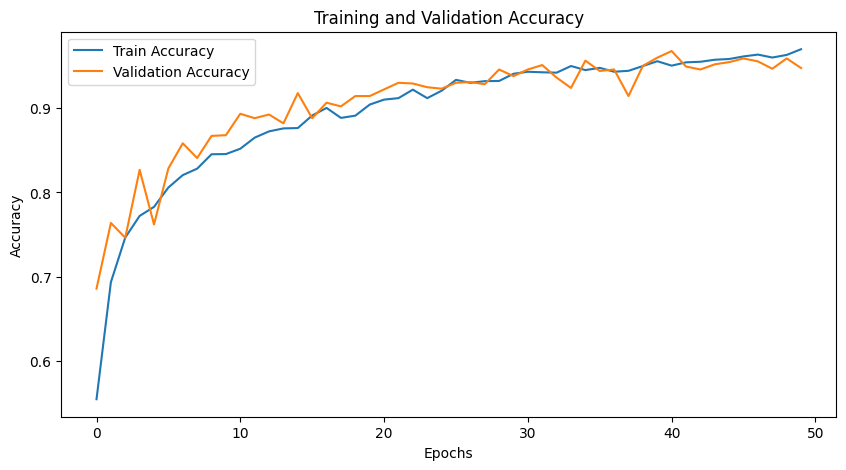

In [26]:
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


##prediction

In [27]:
def predict_image(image_path):
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    class_name = "Tumor" if prediction[0][0] > 0.5 else "No Tumor"
    print(f"Prediction: {class_name}")

# Example usage
predict_image("/content/Te-noTr_0004.jpg")

predict_image("/content/Te-piTr_0006.jpg")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Prediction: No Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction: No Tumor
